# Setting Up

In [1]:
# update your credentials if needed
!git config --global user.email "abduallahw10@gmail.com"
!git config --global user.name "Abdullah Al-Hayali"

In [2]:
# check that we're in the right repo, branch and that we are caught up
!git status

On branch a_new
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   main.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


# Data Loading

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt

In [2]:
# Loading metadata

root_path = "C:\My files\Courses\CIS6050\Data"
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,5,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [7]:
# Entries for each column in the DF

meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822279 entries, 0 to 822278
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          822279 non-null  object 
 1   sha               273415 non-null  object 
 2   source_x          822279 non-null  object 
 3   title             821855 non-null  object 
 4   doi               450166 non-null  object 
 5   pmcid             283183 non-null  object 
 6   pubmed_id         368432 non-null  object 
 7   license           822279 non-null  object 
 8   abstract          615624 non-null  object 
 9   publish_time      822043 non-null  object 
 10  authors           803313 non-null  object 
 11  journal           769703 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  382148 non-null  object 
 14  arxiv_id          10765 non-null   object 
 15  pdf_json_files    273415 non-null  object 
 16  pmc_json_files    22

## Fetch JSON Files

In [8]:
all_json = glob.glob(f'{root_path}/**/*.json', recursive=True)
len(all_json)

517904

In [9]:
all_json[:5]

['C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\0000028b5cc154f68b8a269f6578f21e31f62977.json',
 'C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\0000b6da665726420ab8ac9246d526f2f44d5943.json',
 'C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\0000b93c66f991236db92dc16fa6db119b27ca12.json',
 'C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\0000fcce604204b1b9d876dc073eb529eb5ce305.json',
 'C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\000122a9a774ec76fa35ec0c0f6734e7e8d0c541.json']

In [10]:
all_json[0]

'C:\\My files\\Courses\\CIS6050\\Data\\document_parses\\pdf_json\\0000028b5cc154f68b8a269f6578f21e31f62977.json'

In [11]:
# File reader class

class FileReader:
    def __init__(self, file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.author_info = []
            self.abstract = []
            self.body_text = []
            # Author
            for entry in content['metadata']['authors']:
                self.author_info.append(entry['first'])
                self.author_info.append(entry['last'])
#             print(self.author_info)
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
#             self.author_info = '\n'.join(self.author_info)
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'AUTHOR: {self.author_info}; PAPER ID: {self.paper_id}; ABSTRACT: {self.abstract[:50]}; BODY TEXT: {self.body_text[:50]}'

first_row = FileReader(all_json[2])
print(first_row)

AUTHOR: ['Biju', 'George', 'Sanjay', 'Bhattacharya']; PAPER ID: 0000b93c66f991236db92dc16fa6db119b27ca12; ABSTRACT: ; BODY TEXT: Infections are an important cause of morbidity, mo


In [ ]:
# Filter non-complying JSONS

from tqdm import tqdm

all_json_clean = list()

for idx, content in tqdm(enumerate(all_json)):    
    try:
        content = FileReader(content)
    except Exception as e:
        continue  # invalid paper format, skip
    
    if len(content.abstract) == 0:
        continue
    
    all_json_clean.append(all_json[idx])
    
all_json = all_json_clean
len(all_json)

In [ ]:
from tqdm import tqdm
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'authors': [], 
         'title': [], 'journal': []}
for idx, entry in tqdm(enumerate(all_json), total = len(all_json)):
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    if len(content.body_text) == 0:
        continue
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
                
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')

        dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add title
    dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'authors',
                                        'title', 'journal'])
df_covid.head()

In [12]:
df_covid = pd.read_csv("C:\My files\Courses\CIS6050\mod_df.csv")

In [13]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181580 entries, 0 to 181579
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   paper_id  181580 non-null  object
 1   doi       172525 non-null  object
 2   abstract  181579 non-null  object
 3   authors   180646 non-null  object
 4   title     181580 non-null  object
 5   journal   159444 non-null  object
dtypes: object(6)
memory usage: 8.3+ MB


In [14]:
df_covid.dropna(inplace=True)

In [15]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158167 entries, 0 to 181579
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   paper_id  158167 non-null  object
 1   doi       158167 non-null  object
 2   abstract  158167 non-null  object
 3   authors   158167 non-null  object
 4   title     158167 non-null  object
 5   journal   158167 non-null  object
dtypes: object(6)
memory usage: 8.4+ MB


### NOTE:

The data isn't only English! here's the breakdown (https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/139146):

('en', 28575),
('fr', 323),
('es', 281),
('de', 54),
('it', 19),

In [3]:
from langdetect import detect
from langdetect import DetectorFactory
from tqdm import tqdm

In [19]:
# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df_covid))):
    # split by space into list, take the first x intex, join with space
    text = df_covid.iloc[ii]['abstract'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            
            try:
                # let's try to label it through the abstract then
                lang = detect(df_covid.iloc[ii]['abstract'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|███████████████████████████████████████████████████████████████████████████████████| 158167/158167 [10:51<00:00, 242.64it/s]


In [20]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 158167

{'af': 19,
 'ar': 20,
 'ca': 85,
 'cs': 12,
 'cy': 295,
 'da': 4,
 'de': 1316,
 'el': 1,
 'en': 153558,
 'es': 784,
 'et': 26,
 'fi': 12,
 'fr': 374,
 'hr': 30,
 'hu': 22,
 'id': 169,
 'it': 563,
 'ja': 1,
 'lt': 10,
 'lv': 1,
 'nl': 121,
 'no': 4,
 'pl': 172,
 'pt': 180,
 'ro': 71,
 'ru': 1,
 'sk': 14,
 'sl': 46,
 'so': 12,
 'sq': 5,
 'sv': 8,
 'sw': 29,
 'tl': 38,
 'tr': 19,
 'unknown': 140,
 'vi': 5}


In [21]:
df_covid['language'] = languages
df_covid = df_covid[df_covid['language'] == 'en'] 
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153558 entries, 0 to 181579
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   paper_id  153558 non-null  object
 1   doi       153558 non-null  object
 2   abstract  153558 non-null  object
 3   authors   153558 non-null  object
 4   title     153558 non-null  object
 5   journal   153558 non-null  object
 6   language  153558 non-null  object
dtypes: object(7)
memory usage: 9.4+ MB


# In case of reloading, START HERE and load clean_df.csv

In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg

In [4]:
df_covid=pd.read_csv("C:\My files\Courses\CIS6050\clean_df.csv")

In [5]:
df_covid.head()

,paper_id,doi,abstract,authors,title,journal,language
0,0000b6da665726420ab8ac9246d526f2f44d5943,10.1002/lio2.665,Objective: An at home-test for differentiating...,"Yang, Alex. Lewis, Robert J.. Watson, Nora. ...",The cell phone vibration test: A telemedicine ...,Laryngoscope Investig Otolaryngol,en
1,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. P...",Impact of COVID-19 on ST-segment elevation myo...,Rev Esp Cardiol (Engl Ed),en
2,00013694fb8095bb818b64346f791a5419d97c88,10.1007/s43545-021-00122-9,Prolonged Covid-19-related school closures in ...,"Canovan, Cherry. Fallon, Naomi",Widening the divide: the impact of school clos...,SN Soc Sci,en
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,"Cornelissen, E.. Dewerchin, H.L.. Van Hamme,...",Absence of surface expression of feline infect...,Vet Microbiol,en
4,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...","Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho ...,Data Science and Digital Transformation in the...,en


When doing topic modelling, the word embeddings are critical

In [6]:
# Remove noisy data
stopwords = list(STOP_WORDS)
stopwords[:10]

['hereupon',
 'beside',
 'side',
 'every',
 'bottom',
 'my',
 'hereafter',
 "'ll",
 'mine',
 'before']

You can increase accuracy by adding custom stopwords but we'll skip them for now.

In [7]:
# Text parsing to change everything to lowercase, remove punctuation, find and remove stopwords
# en_core_sci_lg will be used to process biomedical text
"https://allenai.github.io/scispacy/"
#https://github.com/allenai/scispacy SciBERT could be a future suggestion


parser = en_core_sci_lg.load(disable=["tagger", "ner"]) 
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [8]:
tqdm.pandas()
df_covid["processed_text"] = df_covid["abstract"].progress_apply(spacy_tokenizer)

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 153558/153558 [33:48<00:00, 75.69it/s]


In [9]:
df_covid.head()

,paper_id,doi,abstract,authors,title,journal,language,processed_text
0,0000b6da665726420ab8ac9246d526f2f44d5943,10.1002/lio2.665,Objective: An at home-test for differentiating...,"Yang, Alex. Lewis, Robert J.. Watson, Nora. ...",The cell phone vibration test: A telemedicine ...,Laryngoscope Investig Otolaryngol,en,objective : home-test differentiate conductive...
1,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. P...",Impact of COVID-19 on ST-segment elevation myo...,Rev Esp Cardiol (Engl Ed),en,introduction objective : covid-19 outbreak unc...
2,00013694fb8095bb818b64346f791a5419d97c88,10.1007/s43545-021-00122-9,Prolonged Covid-19-related school closures in ...,"Canovan, Cherry. Fallon, Naomi",Widening the divide: the impact of school clos...,SN Soc Sci,en,prolonged covid-19-related school closure uk r...
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,"Cornelissen, E.. Dewerchin, H.L.. Van Hamme,...",Absence of surface expression of feline infect...,Vet Microbiol,en,feline infectious peritonitis virus ( fipv ) p...
4,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...","Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho ...,Data Science and Digital Transformation in the...,en,"cctv surveillance center ( "" center "" ) seocho..."


In [10]:
# tf-idf will be used to convert the string into a measure of importance

from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [11]:
# Vectorize the data

text = df_covid['processed_text'].values
#not sure how this works. Got it from the discussions
max_words = 2**10 #max number of features/words of interest

X = vectorize(text, max_words)

# Dimensionality reduction

In [40]:
#TODO: Try without PCA

Let's see how much we can reduce while we keep 95% variance

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(153558, 856)

In [14]:
# k means clustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [23]:
# elbow method
# https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 21)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

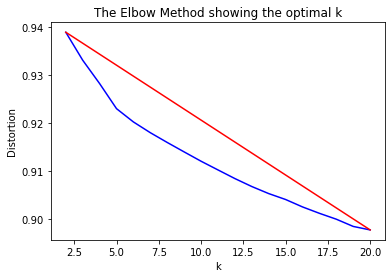

In [24]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [42]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_covid['y_pred_k5'] = y_pred

In [43]:
k = 19
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df_covid['y_pred_k19'] = y_pred

In [44]:
df_covid.head()

,paper_id,doi,abstract,authors,title,journal,language,processed_text,y_pred,y_pred_k5,y_pred_k19
0,0000b6da665726420ab8ac9246d526f2f44d5943,10.1002/lio2.665,Objective: An at home-test for differentiating...,"Yang, Alex. Lewis, Robert J.. Watson, Nora. ...",The cell phone vibration test: A telemedicine ...,Laryngoscope Investig Otolaryngol,en,objective : home-test differentiate conductive...,3,3,4
1,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. P...",Impact of COVID-19 on ST-segment elevation myo...,Rev Esp Cardiol (Engl Ed),en,introduction objective : covid-19 outbreak unc...,3,3,4
2,00013694fb8095bb818b64346f791a5419d97c88,10.1007/s43545-021-00122-9,Prolonged Covid-19-related school closures in ...,"Canovan, Cherry. Fallon, Naomi",Widening the divide: the impact of school clos...,SN Soc Sci,en,prolonged covid-19-related school closure uk r...,1,1,16
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,"Cornelissen, E.. Dewerchin, H.L.. Van Hamme,...",Absence of surface expression of feline infect...,Vet Microbiol,en,feline infectious peritonitis virus ( fipv ) p...,0,0,15
4,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...","Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho ...,Data Science and Digital Transformation in the...,en,"cctv surveillance center ( "" center "" ) seocho...",1,1,5


In [46]:
df_covid = df_covid.drop('y_pred',1)

In [47]:
df_covid.head()

,paper_id,doi,abstract,authors,title,journal,language,processed_text,y_pred_k5,y_pred_k19
0,0000b6da665726420ab8ac9246d526f2f44d5943,10.1002/lio2.665,Objective: An at home-test for differentiating...,"Yang, Alex. Lewis, Robert J.. Watson, Nora. ...",The cell phone vibration test: A telemedicine ...,Laryngoscope Investig Otolaryngol,en,objective : home-test differentiate conductive...,3,4
1,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. P...",Impact of COVID-19 on ST-segment elevation myo...,Rev Esp Cardiol (Engl Ed),en,introduction objective : covid-19 outbreak unc...,3,4
2,00013694fb8095bb818b64346f791a5419d97c88,10.1007/s43545-021-00122-9,Prolonged Covid-19-related school closures in ...,"Canovan, Cherry. Fallon, Naomi",Widening the divide: the impact of school clos...,SN Soc Sci,en,prolonged covid-19-related school closure uk r...,1,16
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,"Cornelissen, E.. Dewerchin, H.L.. Van Hamme,...",Absence of surface expression of feline infect...,Vet Microbiol,en,feline infectious peritonitis virus ( fipv ) p...,0,15
4,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...","Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho ...,Data Science and Digital Transformation in the...,en,"cctv surveillance center ( "" center "" ) seocho...",1,5


In [48]:
df_covid.to_csv("df_clean.csv", index=False)

# LDA

## RUN df_clean.csv here, you can ignore everything beforehand

In [49]:
df_covid.head()

,paper_id,doi,abstract,authors,title,journal,language,processed_text,y_pred_k5,y_pred_k19
0,0000b6da665726420ab8ac9246d526f2f44d5943,10.1002/lio2.665,Objective: An at home-test for differentiating...,"Yang, Alex. Lewis, Robert J.. Watson, Nora. ...",The cell phone vibration test: A telemedicine ...,Laryngoscope Investig Otolaryngol,en,objective : home-test differentiate conductive...,3,4
1,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Introduction and objectives: The COVID-19 outb...,"Rodríguez-Leor, Oriol. Cid-Álvarez, Belén. P...",Impact of COVID-19 on ST-segment elevation myo...,Rev Esp Cardiol (Engl Ed),en,introduction objective : covid-19 outbreak unc...,3,4
2,00013694fb8095bb818b64346f791a5419d97c88,10.1007/s43545-021-00122-9,Prolonged Covid-19-related school closures in ...,"Canovan, Cherry. Fallon, Naomi",Widening the divide: the impact of school clos...,SN Soc Sci,en,prolonged covid-19-related school closure uk r...,1,16
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Feline infectious peritonitis virus (FIPV) pos...,"Cornelissen, E.. Dewerchin, H.L.. Van Hamme,...",Absence of surface expression of feline infect...,Vet Microbiol,en,feline infectious peritonitis virus ( fipv ) p...,0,15
4,000159d40045de3f55c9ddd5d99d760d679d4910,10.1007/978-3-030-64769-8_13,"The CCTV surveillance center (below to ""Center...","Lim, Donghyun. Park, Deawoo",AI Analysis of Illegal Parking Data at Seocho ...,Data Science and Digital Transformation in the...,en,"cctv surveillance center ( "" center "" ) seocho...",1,5


In [67]:
df_covid['processed_text']

0         objective : home-test differentiate conductive...
1         introduction objective : covid-19 outbreak unc...
2         prolonged covid-19-related school closure uk r...
3         feline infectious peritonitis virus ( fipv ) p...
4         cctv surveillance center ( " center " ) seocho...
                                ...                        
153553    covid-19 pandemic , despite widespread social ...
153554    global radial basis functions ( rbfs ) lead il...
153555    publication type : original research article w...
153556    protect human life , science public health nee...
153557    studies activity rhythm pivotal management inv...
Name: processed_text, Length: 153558, dtype: object

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

create vectorizers for the k clusters

In [53]:
vectorizers = []
    
for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [56]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

vectorize the data from each cluster

In [57]:
# Vectorize the data for each vector

vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df_covid.loc[df_covid['y_pred_k19'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

Not enough instances in cluster: 19


In [58]:
len(vectorized_data)

20

In [59]:
# number of topics per cluster, this was RANDOMLY selected
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [60]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [62]:
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(lda))

Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)
Current Cluster: LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose

In [63]:
# Functions for printing keywords for each topic 
#From discussion forums

def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [64]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [65]:
print(all_keywords,"\n", len(all_keywords))

[['learn', 'online', 'education', 'clinical', 'pandemic', 'teach', 'covid-', 'study', 'teacher', 'research', 'medical', 'use', 'group', 'train', 'school', 'questionnaire', 'university', 'mental', 'stress', 'health', 'program', 'international', 'course', 'language', 'score', 'infection', 'career', 'risk', 'time', 'intention', 'exam', 'control', 'perceive', 'model', 'english', 'leadership', 'exercise', 'sexual', 'tutor', 'biology', 'pathology', 'entrepreneurial', 'science', 'org', 'ethical', 'business', 'entrepreneurship', 'error', 'personality', 'trait', 'neuroscience', 'character', 'physicians'], ['ace', 'drug', 'rna', 'membrane', 'spike', 'antibody', 'nsp', 'sars-cov-', 'fusion', 'structure', 'bind', 'epitope', 'study', 'host', 'cell', 'vaccine', 'target', 'gene', 'orf', 'sequence', 'peptide', 'expression', 'viral', 'disease', 'fig', 'model', 'virus', 'acid', 'function', 'family', 'particle', 'virion', 'conformation', 'patient', 'effect', 'state', 'ubiquitin', 'kinase', 'prrsv', 'mass

### LDA for every single paper

Adpoted from https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [6]:
df_covid=pd.read_csv("C:\My files\Courses\CIS6050\df_clean.csv")

In [60]:
paper_ids = df_covid['paper_id']

In [62]:
paper_ids[0]

'0000b6da665726420ab8ac9246d526f2f44d5943'

In [7]:
df_text_s = df_covid['processed_text']

In [8]:
df_text_s

0         objective : home-test differentiate conductive...
1         introduction objective : covid-19 outbreak unc...
2         prolonged covid-19-related school closure uk r...
3         feline infectious peritonitis virus ( fipv ) p...
4         cctv surveillance center ( " center " ) seocho...
                                ...                        
153553    covid-19 pandemic , despite widespread social ...
153554    global radial basis functions ( rbfs ) lead il...
153555    publication type : original research article w...
153556    protect human life , science public health nee...
153557    studies activity rhythm pivotal management inv...
Name: processed_text, Length: 153558, dtype: object

In [9]:
import gensim

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [11]:
data = df_text_s.values.tolist()
data_words = list(sent_to_words(data))

In [14]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

[(4, 1), (36, 1), (43, 3), (48, 2), (60, 1), (67, 3), (77, 2), (102, 1), (117, 1), (148, 1), (158, 1), (175, 1), (176, 2), (177, 1), (178, 2), (179, 1), (180, 1), (181, 1), (182, 1), (183, 3), (184, 1), (185, 1), (186, 1), (187, 1), (188, 2), (189, 1), (190, 1), (191, 1), (192, 2), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 3), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 3), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 3), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 2), (234, 3), (235, 8), (236, 1), (237, 2), (238, 3), (239, 1), (240, 1), (241, 1), (242, 1), (243, 1), (244, 1)]


Gensim creates unique id for each word in the document. Its mapping of word_id and word_frequency. Example: (4,1) above indicates, word_id 4 occurs once in the document and so on.

In [38]:
# View
print(corpus[2])

[(4, 1), (36, 1), (43, 3), (48, 2), (60, 1), (67, 3), (77, 2), (102, 1), (117, 1), (148, 1), (158, 1), (175, 1), (176, 2), (177, 1), (178, 2), (179, 1), (180, 1), (181, 1), (182, 1), (183, 3), (184, 1), (185, 1), (186, 1), (187, 1), (188, 2), (189, 1), (190, 1), (191, 1), (192, 2), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1), (200, 1), (201, 1), (202, 1), (203, 1), (204, 1), (205, 1), (206, 3), (207, 1), (208, 1), (209, 1), (210, 1), (211, 1), (212, 3), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 3), (221, 1), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 2), (234, 3), (235, 8), (236, 1), (237, 2), (238, 3), (239, 1), (240, 1), (241, 1), (242, 1), (243, 1), (244, 1)]


In [89]:
from pprint import pprint

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=NUM_TOPICS_PER_CLUSTER)
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"study" + 0.007*"covid" + 0.007*"datum" + 0.006*"use" + '
  '0.006*"health" + 0.005*"model" + 0.004*"research" + 0.004*"time" + '
  '0.004*"case" + 0.004*"analysis"'),
 (1,
  '0.018*"covid" + 0.018*"patient" + 0.009*"study" + 0.008*"sars" + '
  '0.008*"cov" + 0.007*"high" + 0.007*"group" + 0.007*"use" + '
  '0.006*"infection" + 0.005*"severe"'),
 (2,
  '0.021*"sars" + 0.018*"cov" + 0.013*"covid" + 0.012*"test" + 0.009*"patient" '
  '+ 0.006*"use" + 0.006*"infection" + 0.006*"virus" + 0.006*"study" + '
  '0.005*"coronavirus"'),
 (3,
  '0.017*"covid" + 0.016*"patient" + 0.012*"health" + 0.009*"pandemic" + '
  '0.008*"study" + 0.007*"care" + 0.007*"disease" + 0.005*"use" + 0.005*"high" '
  '+ 0.005*"risk"'),
 (4,
  '0.015*"patient" + 0.010*"use" + 0.010*"study" + 0.008*"model" + 0.007*"ci" '
  '+ 0.007*"mortality" + 0.006*"covid" + 0.005*"rate" + 0.004*"hospital" + '
  '0.004*"datum"'),
 (5,
  '0.011*"covid" + 0.011*"use" + 0.008*"study" + 0.007*"health" + '
  '0.006*"patien

In [98]:
def extractDigits(lst):
    return [[el] for el in lst]

#Change a list of words to list of lists
ll_words = extractDigits(data_words[0])

# Create Dictionary
id2word_t = corpora.Dictionary(ll_words)

# Create Corpus
texts_t = ll_words

# Term Document Frequency
corpus_t = [id2word.doc2bow(text) for text in texts_t]    

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus_t,
                                       id2word=id2word_t,
                                       num_topics=NUM_TOPICS_PER_CLUSTER)

In [102]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_t]

[(0,
  '0.096*"administer" + 0.050*"test" + 0.050*"provide" + 0.050*"similar" + '
  '0.050*"sound" + 0.050*"determine" + 0.050*"sectional" + 0.050*"patient" + '
  '0.050*"evidence" + 0.050*"novel"'),
 (1,
  '0.125*"wtft" + 0.065*"telemedicine" + 0.065*"provide" + 0.065*"finding" + '
  '0.065*"perceive" + 0.065*"report" + 0.065*"design" + 0.006*"reliably" + '
  '0.006*"hz" + 0.006*"recent"'),
 (2,
  '0.130*"consistent" + 0.046*"hz" + 0.046*"telemedicine" + 0.046*"loud" + '
  '0.046*"wtft" + 0.046*"audiogram" + 0.046*"self" + 0.046*"cell" + '
  '0.046*"hear" + 0.046*"differentiate"'),
 (3,
  '0.149*"consecutive" + 0.053*"reliably" + 0.053*"calculate" + 0.053*"assess" '
  '+ 0.053*"weber" + 0.053*"fork" + 0.053*"expect" + 0.053*"conductive" + '
  '0.053*"vibrate" + 0.053*"study"'),
 (4,
  '0.097*"reliably" + 0.097*"loud" + 0.066*"audiogram" + 0.066*"telemedicine" '
  '+ 0.035*"cpvt" + 0.035*"similar" + 0.035*"recent" + 0.035*"cohort" + '
  '0.035*"involve" + 0.035*"remain"'),
 (5,
  '0.18

In [97]:
data_words[2]

['prolonged',
 'covid',
 'related',
 'school',
 'closure',
 'uk',
 'raise',
 'concern',
 'science',
 'teach',
 'learn',
 'primary',
 'level',
 'negative',
 'impact',
 'paper',
 'report',
 'finding',
 'phase',
 'study',
 'author',
 'conduct',
 'teacher',
 'parent',
 'explore',
 'issue',
 'find',
 'significant',
 'proportion',
 'teacher',
 'provide',
 'little',
 'science',
 'lockdown',
 'normal',
 'school',
 'week',
 'teachers',
 'particularly',
 'work',
 'deprive',
 'area',
 'report',
 'translate',
 'science',
 'curriculum',
 'home',
 'learn',
 'difficult',
 'concern',
 'resource',
 'internet',
 'access',
 'parental',
 'ability',
 'help',
 'area',
 'curriculum',
 'pose',
 'particular',
 'difficulty',
 'lead',
 'narrow',
 'topic',
 'teach',
 'teacher',
 'parent',
 'feel',
 'school',
 'prioritise',
 'english',
 'math',
 'science',
 'parent',
 'report',
 'child',
 'engage',
 'sophisticate',
 'extracurricular',
 'activity',
 'bolster',
 'resource',
 'available',
 'home',
 'knowledgeable',
 

In [101]:
corpus_t

[[(54, 1)],
 [(43, 1)],
 [(80, 1)],
 [(29, 1)],
 [(21, 1)],
 [(72, 1)],
 [(42, 1)],
 [(49, 1)],
 [(66, 1)],
 [(31, 1)],
 [(40, 1)],
 [(83, 1)],
 [(53, 1)],
 [(12, 1)],
 [(58, 1)],
 [(85, 1)],
 [(80, 1)],
 [(25, 1)],
 [(86, 1)],
 [(81, 1)],
 [(38, 1)],
 [(80, 1)],
 [(87, 1)],
 [(7, 1)],
 [(25, 1)],
 [(71, 1)],
 [(2, 1)],
 [(55, 1)],
 [(65, 1)],
 [(77, 1)],
 [(27, 1)],
 [(26, 1)],
 [(70, 1)],
 [(51, 1)],
 [(25, 1)],
 [(46, 1)],
 [(59, 1)],
 [(84, 1)],
 [(13, 1)],
 [(14, 1)],
 [(37, 1)],
 [(28, 1)],
 [(30, 1)],
 [(56, 1)],
 [(74, 1)],
 [(50, 1)],
 [(22, 1)],
 [(4, 1)],
 [(55, 1)],
 [(8, 1)],
 [(52, 1)],
 [(67, 1)],
 [(63, 1)],
 [(42, 1)],
 [(15, 1)],
 [(64, 1)],
 [(41, 1)],
 [(23, 1)],
 [(55, 1)],
 [(34, 1)],
 [(61, 1)],
 [(25, 1)],
 [(87, 1)],
 [(82, 1)],
 [(81, 1)],
 [(38, 1)],
 [(44, 1)],
 [(41, 1)],
 [(23, 1)],
 [(1, 1)],
 [(55, 1)],
 [(62, 1)],
 [(45, 1)],
 [(25, 1)],
 [(47, 1)],
 [(75, 1)],
 [(11, 1)],
 [(7, 1)],
 [(76, 1)],
 [(20, 1)],
 [(25, 1)],
 [(87, 1)],
 [(9, 1)],
 [(36, 1)],

In [69]:
def extractDigits(lst):
    return [[el] for el in lst]

In [94]:
from pprint import pprint

NUM_TOPICS_PER_CLUSTER = 10
abs_lda = []

for i in tqdm(range(0,5)):
    
    print(i)
    
    #Change a list of words to list of lists
    ll_words = extractDigits(data_words[i])
#     print(ll_words)

    # Create Dictionary
    id2word_t = corpora.Dictionary(ll_words)
#     print(id2word_t)
    
    # Create Corpus
    texts_t = ll_words
    print(texts_t)
    
    # Term Document Frequency
    corpus_t = [id2word.doc2bow(text) for text in texts_t]
    print(corpus_t)

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus_t,
                                           id2word=id2word_t,
                                           num_topics=NUM_TOPICS_PER_CLUSTER)
        
    abs_lda.append(lda_model[corpus_t])

  0%|                                                                                                                                                                                                               | 0/5 [00:00<?, ?it/s]

0
[['objective'], ['home'], ['test'], ['differentiate'], ['conductive'], ['sensorineural'], ['hear'], ['loss'], ['remain'], ['elusive'], ['goal'], ['validate'], ['novel'], ['cell'], ['phone'], ['vibration'], ['test'], ['cpvt'], ['weber'], ['tune'], ['fork'], ['test'], ['wtft'], ['assess'], ['cpvt'], ['self'], ['administer'], ['patient'], ['reliably'], ['study'], ['design'], ['cross'], ['sectional'], ['methods'], ['cpvt'], ['involve'], ['placement'], ['vibrate'], ['cellphone'], ['center'], ['forehead'], ['determine'], ['ear'], ['perceive'], ['sound'], ['loud'], ['consecutive'], ['adult'], ['patient'], ['audiogram'], ['month'], ['report'], ['recent'], ['hear'], ['change'], ['recruit'], ['group'], ['consist'], ['patient'], ['examine'], ['provider'], ['cpvt'], ['wtft'], ['use'], ['tune'], ['fork'], ['hz'], ['group'], ['consist'], ['additional'], ['patient'], ['receive'], ['instruction'], ['cpvt'], ['kappa'], ['statistic'], ['calculate'], ['assess'], ['strength'], ['concordance'], ['cpvt'],

 20%|███████████████████████████████████████▊                                                                                                                                                               | 1/5 [00:07<00:30,  7.58s/it]

1
[['introduction'], ['objective'], ['covid'], ['outbreak'], ['unclear'], ['impact'], ['treatment'], ['outcome'], ['patient'], ['st'], ['segment'], ['elevation'], ['myocardial'], ['infarction'], ['stemi'], ['aim'], ['study'], ['assess'], ['change'], ['stemi'], ['management'], ['covid'], ['outbreak'], ['methods'], ['multicenter'], ['nationwide'], ['retrospective'], ['observational'], ['registry'], ['consecutive'], ['patient'], ['manage'], ['specific'], ['stemi'], ['care'], ['center'], ['spain'], ['compare'], ['patient'], ['procedural'], ['characteristic'], ['in'], ['hospital'], ['outcome'], ['different'], ['cohort'], ['day'], ['follow'], ['up'], ['accord'], ['patient'], ['treat'], ['covid'], ['results'], ['suspected'], ['stemi'], ['patient'], ['treat'], ['stemi'], ['network'], ['decrease'], ['patient'], ['confirm'], ['stemi'], ['fall'], ['difference'], ['reperfusion'], ['strategy'], ['treat'], ['primary'], ['percutaneous'], ['coronary'], ['intervention'], ['cohort'], ['patients'], ['tre

 20%|███████████████████████████████████████▊                                                                                                                                                               | 1/5 [00:32<02:11, 32.98s/it]


KeyboardInterrupt: 

In [71]:
pprint(lda_model.print_topics())
doc_lda = lda_model[abs_lda(1)]

abs_lda

{'0000b6da665726420ab8ac9246d526f2f44d5943': <gensim.interfaces.TransformedCorpus at 0x162c0aa1160>}

In [80]:
abs_lda

[]

#### The next cells export the filtered all_json list into a DF

In [ ]:
new_jj = all_json[:]
len(new_jj)

In [ ]:
import os

In [ ]:
# Return the longest prefix of all list elements.
def commonprefix(m):
    "Given a list of pathnames, returns the longest common leading component"
    if not m: return ''
    s1 = min(m)
    s2 = max(m)
    for i, c in enumerate(s1):
        if c != s2[i]:
            return s1[:i]
    return s1

In [ ]:
commonprefix(new_jj)

In [ ]:
len(new_jj)

In [ ]:
df_test22 = pd.DataFrame(new_jj)
df_test22.to_csv('Paths_JSON_clean.csv', index=False)

In [ ]:
# Scrap code

print("empty count", meta_df['abstract'].isnull().sum())

In [ ]:
print(meta_df['abstract'].notnull().sum())

# Pushing The Code

In [ ]:
!git branch "a_new"

In [ ]:
!git checkout "a_new"

In [ ]:
!git status

In [ ]:
!git add .

In [ ]:
!git push origin a_new

In [ ]:
!git checkout main

In [ ]:
!git commit -m"More clean df"

In [ ]:
!git status